In [40]:
import numpy as np
import pandas as pd
import os
from load_testdata import read_poly_coefficients, read_profile_pepsi, load_xyz, read_sasbdb
from debyecalc_Iq import DebyeCalculator
from collections import defaultdict
import glob
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [41]:
poly_coeffs = read_poly_coefficients('../poly_atev.csv')

#poly = poly_coeffs[poly_coeffs[:,0]=='H2O',2]
#print(poly)

def getfitted_ff(aa, q, polyA):
    """ Get the fitted form factor for a given amino acid
        q is the scattering vector
    Args:
        aa (str): Amino acid
        q (np.array): scattering vector
    returns:
        f (np.array): fitted form factor
    """
    result = np.zeros(len(q))
    poly = polyA[polyA[:,0]==aa,2]
    result = poly[0]+poly[1]*q+poly[2]*q**2+poly[3]*q**3+poly[4]*q**4+poly[5]*q**5+poly[6]*q**6
    return result


qrange = np.linspace(0, 0.5, 101)
xyz_file = "../cg_structures/ala.xyz"

AA = pd.read_csv(xyz_file)
print(AA)
amino_acid = np.array(['ALA'])
coordinates = np.array([12.5064, 7.9314, 4.5896])
print(coordinates)
atFF = np.array([getfitted_ff(amino_acid, qrange, poly_coeffs)])
print(atFF[0,0]) 



                           1
0  ALA 12.5064 7.9314 4.5896
[12.5064  7.9314  4.5896]
8.9412587775497


In [42]:
dist = np.linalg.norm(coordinates)

Iq_analytical = np.zeros(len(qrange))
for i, q in enumerate(qrange):
    if q == 0:
        Iq_analytical[i] = atFF[0,i]**2  
    else:   
        Iq_analytical[i] = atFF[0,i]**2 * 1
print(Iq_analytical)

[ 79.94610853  79.9532298   79.97444797  80.00954751  80.05831676
  80.12054775  80.19603599  80.28458038  80.385983    80.50004898
  80.62658635  80.76540588  80.91632093  81.07914736  81.25370332
  81.43980918  81.63728737  81.84596224  82.06565999  82.29620849
  82.53743723  82.78917712  83.05126048  83.32352086  83.60579298
  83.89791262  84.19971652  84.51104229  84.83172833  85.16161374
  85.50053824  85.8483421   86.20486604  86.56995119  86.943439
  87.3251712   87.7149897   88.11273657  88.51825396  88.93138405
  89.35196903  89.77985101  90.214872    90.65687387  91.10569831
  91.5611868   92.02318056  92.49152055  92.96604742  93.44660149
  93.93302275  94.42515081  94.92282492  95.42588391  95.93416623
  96.4475099   96.96575255  97.48873136  98.01628311  98.54824414
  99.08445039  99.62473738 100.16894023 100.71689366 101.268432
 101.82338923 102.38159896 102.94289447 103.50710873 104.07407438
 104.64362383 105.2155892  105.78980242 106.36609519 106.94429907
 107.52424546 

In [43]:
out_file = "../pepsi-saxs_data/ala.out"
log_file = "../pepsi-saxs_data/ala.log"

Iq_tot, Iat, Iev, Ihs, atev, aths, evhs, q_pepsi, pepsi_scaling = read_profile_pepsi(out_file, log_file)

Scaling: 6.72782e-07


In [44]:
water, coordsw = load_xyz("../pepsi-saxs_data/nocom.xyz")

water_ff = np.array([getfitted_ff('H2O', qrange, poly_coeffs)])

debye = DebyeCalculator()
dgram = np.zeros((len(coordsw)))
print(dgram.shape, coordsw[0], coordinates)
for i, q in enumerate(coordsw):
    dgram[i] = np.linalg.norm((coordsw[i] - coordinates))
print(atFF[0,1], water_ff[0,1], dgram.shape)
I_ala_aths = np.zeros(len(qrange))


def debye_ala(dgram, q, water_ff, atFF, eps=1e-8):
    ff2 = water_ff * atFF #all water form factors times all amino acid form factor
    ff2_list = np.array([ff2 for _ in range(dgram.shape[0])])
    if q == 0:
        return np.sum(ff2_list)
    else:
        Iq = np.zeros_like(dgram)
        dq = dgram * q
        indices_zeros = dq<eps
        indices_nonzeros = ~indices_zeros
        
        Iq[indices_nonzeros] = ff2_list[indices_nonzeros]  * np.sin(dq[indices_nonzeros]) / dq[indices_nonzeros]
        Iq[indices_zeros] = ff2_list[indices_zeros] * (1 - (1/6) * (dq[indices_zeros])**2)
        return np.sum(Iq)

for i, q in enumerate(qrange):
    I_ala_aths[i] = debye_ala(dgram, q, water_ff[0,i], atFF[0,i])      

(30,) [9.604 1.618 2.561] [12.5064  7.9314  4.5896]
8.941656994329183 9.99807684993221 (30,)


In [45]:
dwater = debye.calculate_distogram(coordsw)
print(dwater.shape)
water_ff = np.array([getfitted_ff('H2O', qrange, poly_coeffs) for _ in range(len(coordsw))])
I_water = np.zeros(len(qrange))
for i, q in enumerate(qrange):
    I_water[i] = debye.debye_mem(dwater, q, water_ff[:,i])



(30, 30)


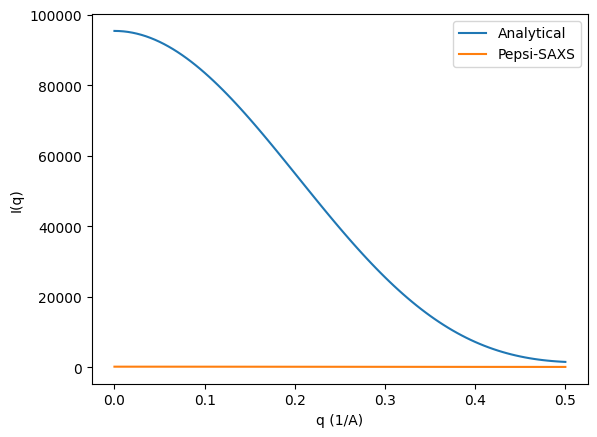

In [46]:
plt.figure()
plt.plot(qrange, Iq_analytical + I_water + 2*I_ala_aths, label='Analytical')
plt.plot(q_pepsi, Iq_tot, label='Pepsi-SAXS')
plt.xlabel('q (1/A)')
plt.ylabel('I(q)')
plt.legend()
plt.show()

In [ ]:

#water_pos = generate_hydration_shell(coordinates, cell_size=5.0, padding=12.0, min_dist=5.0, shell_width=5.0)
qvals, Iqvals = debye.calculate_Iq(xyz_file, poly_coeffs, water_pos)